In [1]:
using CausalForest
using StatsBase
using Plots
using Random
using Distributions
using RCall
using BenchmarkTools
using DelimitedFiles

In [2]:
Random.seed!(123);
n, m = 10^4, 10;
u = Uniform(0,10);
features = rand(u, (n, m));
X = features;
d = Normal();
eps = rand(d, n);
b = Bernoulli();
T = convert(Vector{Int64},rand(b, n));
Y = 25*sin.(features*[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).*T  + features*[0, 0, 2, 0, 0, 0, 3, 0, 0, 0];

In [3]:
df = hcat(X,T,Y)

10000×12 Matrix{Float64}:
 9.063     0.273863  9.2398     …  8.02953    8.61508   1.0   41.2264
 4.43494   8.65398   4.38668       4.26558    5.79587   0.0   10.2415
 7.45673   7.98071   9.35901       7.38559    9.99516   0.0   27.5137
 5.12083   8.25448   8.79223       0.835565   8.06585   0.0   24.796
 2.53849   5.30423   5.84012       0.570453   9.6668    0.0   22.6625
 3.34152   2.66141   9.8669     …  0.92876    9.49805   1.0   20.3578
 4.27328   8.75436   0.0258112     5.12688    2.24987   1.0  -13.6265
 8.67547   7.27313   0.151025      0.0873517  0.765286  0.0   25.0373
 0.991336  1.20752   5.87184       8.38971    9.81301   0.0   20.8175
 1.25287   6.88003   3.64868       4.16181    3.00126   0.0   26.2578
 6.92209   0.298644  4.84843    …  8.07655    1.49476   0.0   36.4211
 1.36551   1.07227   0.570038      2.53062    7.60498   1.0   45.4647
 0.320967  6.45858   4.85281       9.74512    1.98433   0.0   32.6943
 ⋮                              ⋱                       ⋮    
 1.

In [4]:
#header = ["X1" "X2" "X3" "X4" "X5" "X6" "X7" "X8" "X9" "X10" "T" "Y"]
#writedlm("sinus_causal_4.csv", [header ; df], ",")

In [5]:
reval("set.seed(1)")
Xtest_1 = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
true_effect_1 = 25*sin.(Xtest_1[:, 1]);

In [6]:
function get_all_nodes_in_tree!(
    tree ,
    depth = 3,
    result  = []
    )
    if hasproperty(tree, :featid) && depth > 0
        push!(result, tree.featid)
        get_all_nodes_in_tree!(tree.left, depth-1, result)
        get_all_nodes_in_tree!(tree.right, depth-1, result)
    end
    return result
end

function get_freq(forest, depth=3) 
    ensemble = forest.trees
    n_trees = length(ensemble)
    res = []
    for i = 1:n_trees
        append!(res, get_all_nodes_in_tree!(forest.trees[i].tree, depth))
    end
    return proportionmap(res)
end

get_freq (generic function with 2 methods)

# Critère nouveau

### Subsampling

In [7]:
errors_11 = zeros(100)

cf = build_forest(false, true, Y, T, X, true, 10, 500, 500)
pred = apply_forest(cf, Xtest_1)
errors_11[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = 25*sin.(Xtest[:, 1])
    errors_11[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_11))
println(var(errors_11))

0.11540254097379171
9.244862847318209e-6


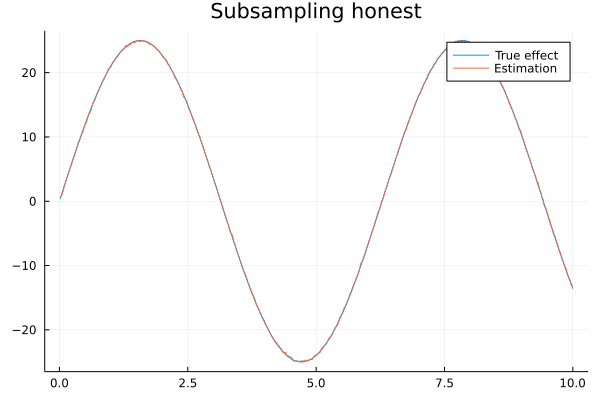

In [8]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Subsampling honest", fmt = :png)

In [9]:
get_freq(cf, 3)

Dict{Any, Float64} with 1 entry:
  1 => 1.0

In [10]:
get_freq(cf, 5)

Dict{Any, Float64} with 8 entries:
  4  => 0.00032438
  6  => 0.000194628
  2  => 0.000259504
  10 => 0.000129752
  9  => 0.000194628
  8  => 0.000194628
  3  => 6.48761e-5
  1  => 0.998638

In [11]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0106619
  4  => 0.0105684
  6  => 0.0121583
  7  => 0.0113166
  2  => 0.0123103
  10 => 0.0116206
  9  => 0.0108724
  8  => 0.0125091
  3  => 0.0113049
  1  => 0.896678

### Bootstrap

In [12]:
errors_12 = zeros(100)

cf = build_forest(true, true, Y, T, X, true, 10, 500, 500)
pred = apply_forest(cf, Xtest_1)
errors_12[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = 25*sin.(Xtest[:, 1])
    errors_12[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_12))
println(var(errors_12))

0.27405500087933576
5.130804749637835e-5


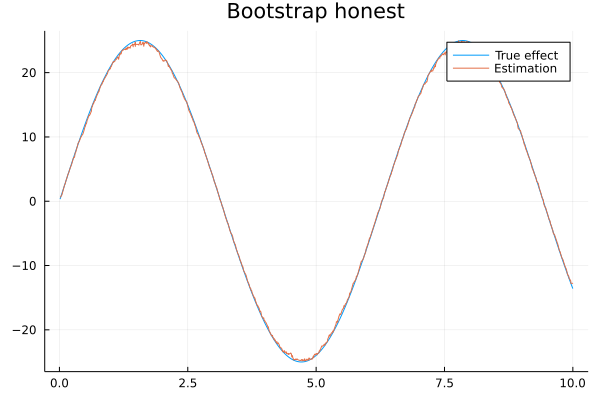

In [13]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Bootstrap honest", fmt = :png)

In [14]:
get_freq(cf, 3)

Dict{Any, Float64} with 1 entry:
  1 => 1.0

In [15]:
get_freq(cf, 5)

Dict{Any, Float64} with 10 entries:
  5  => 0.000906853
  4  => 0.000194326
  6  => 0.000388651
  7  => 0.000518202
  2  => 0.000647752
  10 => 0.000259101
  9  => 0.000712528
  8  => 0.000582977
  3  => 0.000518202
  1  => 0.995271

In [16]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0267061
  4  => 0.0274511
  6  => 0.0283264
  7  => 0.0281588
  2  => 0.0279074
  10 => 0.0278236
  9  => 0.025896
  8  => 0.0280936
  3  => 0.0264734
  1  => 0.753164